In [1]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device='cpu'

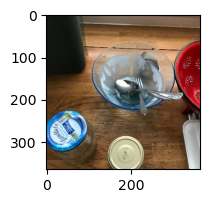

In [24]:
image=Image.open('./example_image.jpg')
plt.figure(figsize=(2,2))
plt.imshow(image)
plt.show()

In [4]:
modelClip, preprocessClip = clip.load("ViT-B/32", device=device)

In [5]:
imageClipPrep = preprocessClip(Image.open("./example_image.jpg")).unsqueeze(0).to(device)

In [42]:
text = clip.tokenize(["something to fill"]).to(device)

In [43]:
with torch.no_grad():
    image_features = modelClip.encode_image(imageClipPrep)
    text_features = modelClip.encode_text(text)
    
    logits_per_image, logits_per_text = modelClip(imageClipPrep, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs) 

Label probs: [[1.]]


In [44]:
#import requests
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

In [45]:
processorCLIPSeg = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
modelCLIPSeg = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [50]:
prompts = ["something to fill"]#["something to fill"]
inputs = processorCLIPSeg(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")

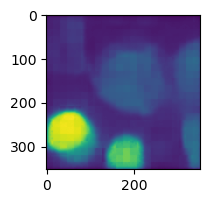

In [60]:
import torch
import matplotlib.pyplot as plt

# predict
with torch.no_grad():
  outputs = modelCLIPSeg(**inputs)

preds = outputs.logits
mask=torch.sigmoid(preds)
plt.figure(figsize=(2,2))
plt.imshow(mask)
plt.show()

In [17]:
def show_points(coords, ax, marker_size=375):
    pos_points = coords
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [19]:
import numpy as np

In [20]:
input_point=np.unravel_index(np.argmax(mask), np.array(mask).shape)
input_point=np.array([[input_point[1],input_point[0]]])
input_point

array([[157, 113]])

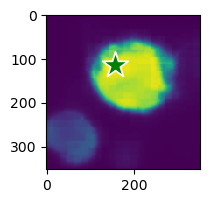

In [22]:
plt.figure(figsize=(2,2))
plt.imshow(mask)
show_points(input_point, plt.gca())
plt.axis('on')
plt.show()

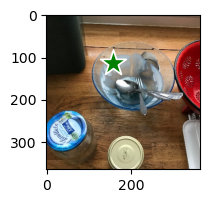

In [23]:
plt.figure(figsize=(2,2))
plt.imshow(image)
show_points(input_point, plt.gca())
plt.axis('on')
plt.show() 

In [26]:
import cv2

In [27]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [28]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_b_01ec64.pth"
#sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [30]:
image = cv2.imread('./example_image.jpg')
predictor.set_image(image)

In [34]:
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
mask=masks[0]
score=scores[0]

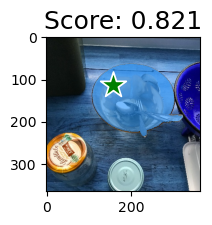

In [37]:
plt.figure(figsize=(2,2))
plt.imshow(image)
show_mask(mask, plt.gca())
show_points(input_point, plt.gca())
plt.title(f"Score: {score:.3f}", fontsize=18)
plt.show() 